# Computer Vision Projects

## Corner Detection & Tracking

First we will import the necessary libraries

In [1]:
import numpy as np
import cv2
import skimage.feature as feature
import matplotlib.pyplot as plt
from scipy import signal
import os
import utils

from pylab import rcParams
rcParams['figure.figsize'] = 15, 20

First we are going to star defining our own implementation of a gaussian kernel. Given a size h, we are going to implement a funcion given a size h, will return a kernel size h x h with a gaussian distribution

In [2]:
def create_gaussian_kernel(size=3, sigma=0.1):
    """
    Creates a Gaussian kernel.

    Args:
    size (int): Size of the kernel. Must be an odd number.
    sigma (float): Standard deviation of the Gaussian kernel.

    Returns:
    numpy.ndarray: A 2D Gaussian kernel or None if the size is not odd.
    """
    # Check that the kernel size is an odd number
    if size % 2 == 0:
        print('Should be an odd number')
        return
    else:
        kernel = np.zeros((size, size))  # Initialize the kernel to zeros

        # Compute the indices for each point in the kernel matrix
        ind = np.indices((size, size))
        ind = ind.transpose(1, 2, 0).reshape(-1, 2)

        # Determine the center of the kernel
        center = np.array([size // 2, size // 2])

        # Compute the offset of each point from the center
        shift = ind - center

        # Fill the kernel with values from the Gaussian distribution
        for i in range(shift.shape[0]):
            x, y = shift[i]
            kernel[x + center[0], y + center[1]] = (1 / (2 * np.pi * sigma**2)) * np.exp(-((x**2 + y**2) / (2 * sigma**2)))
        return kernel * 1/np.sum(kernel)  # Normalize the kernel

def display(img, title=None):
    """
    Displays an image using matplotlib.

    Args:
    img (numpy.ndarray): The image to display.
    title (str, optional): Title of the image. Defaults to None.

    Returns:
    None
    """
    plt.figure()
    plt.imshow(img, cmap='gray')  # Display the image in grayscale
    plt.title(title)  # Set the title of the figure
    plt.axis('off')  # Hide the axes
    plt.show()
    return

Now we are going to apply the sobels filters to the image to obtain the corners in vertical and horizontal direction of the images and thus obtain the images to build the response matrix.

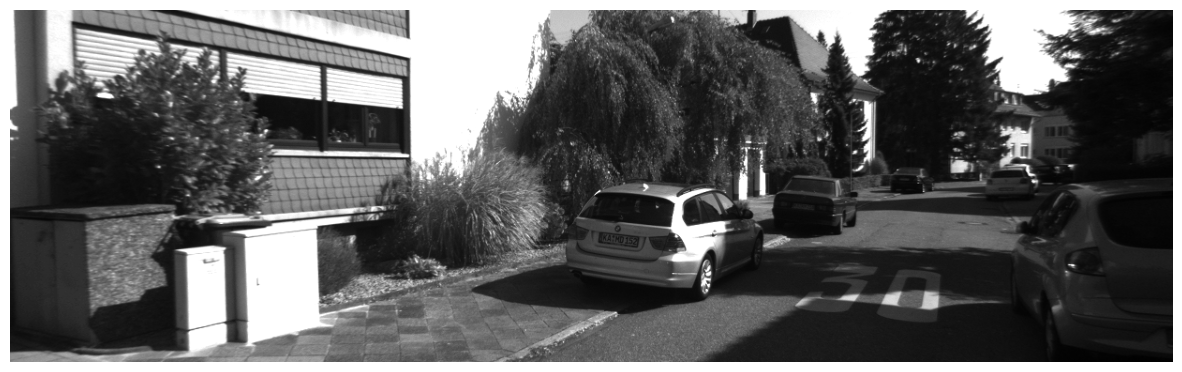

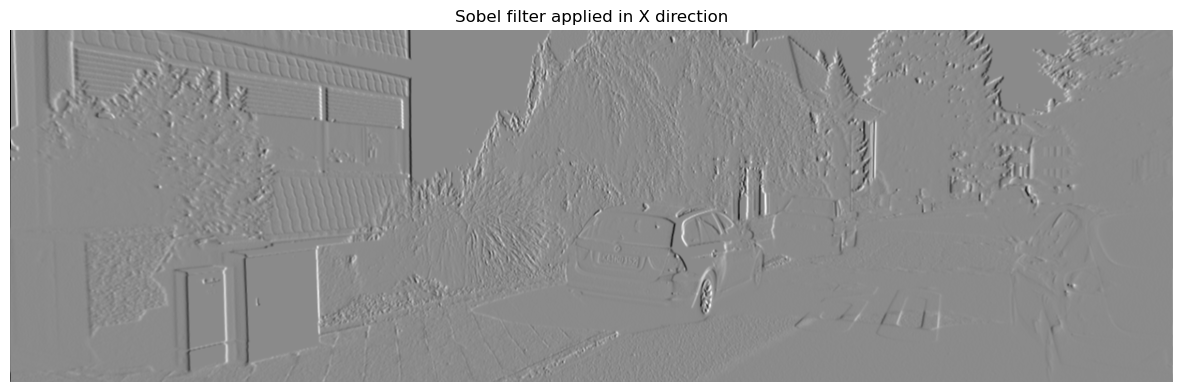

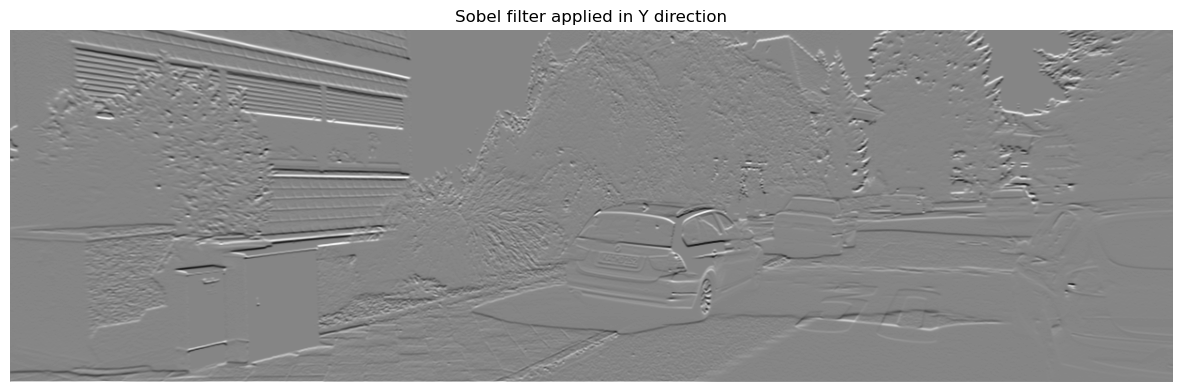

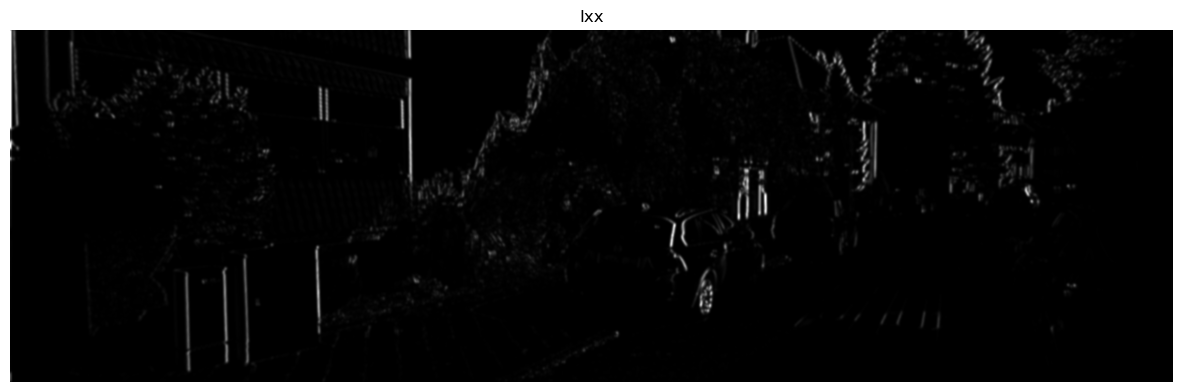

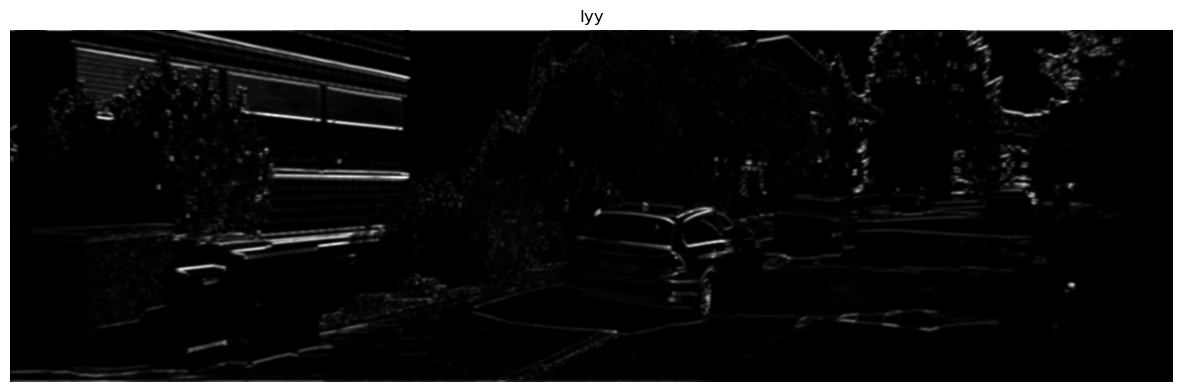

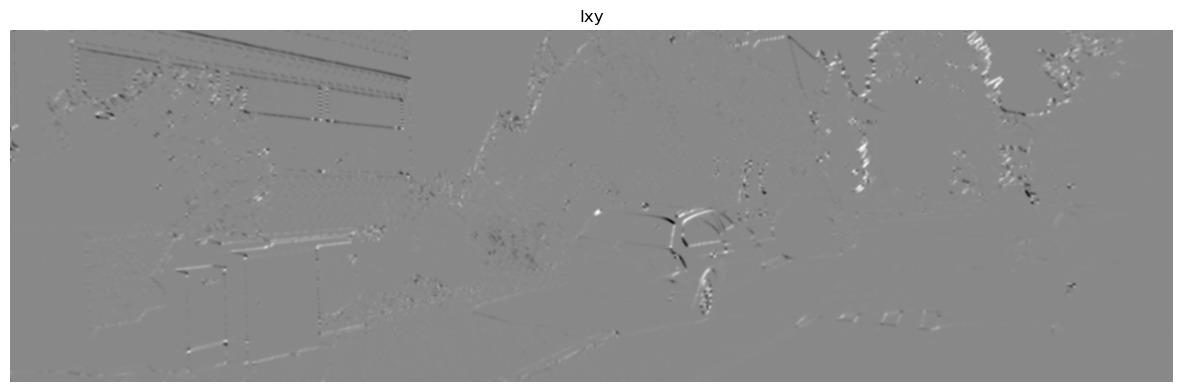

In [3]:
def gradient_image(image):
    """
    Computes the gradients in the x and y directions using the Sobel operator.

    Args:
    image (numpy.ndarray): The image to compute gradients for.

    Returns:
    Tuple[numpy.ndarray, numpy.ndarray]: A pair of arrays, corresponding to the gradients in x (Ix) and y (Iy).
    """
    # Define Sobel filters for detecting gradients in x and y
    Gx = np.array([[-1, 0, 1],
                [-2, 0, 2],
                [-1, 0, 1]])

    Gy = np.array([[-1, -2, -1],
                [0, 0 ,0],
                [1, 2, 1]])
    
    # Apply the Sobel filters to the image
    Ix = signal.convolve2d(image, Gx, mode="same",boundary='fill')
    Iy = signal.convolve2d(image, Gy, mode="same",boundary='fill')
    display(Ix, 'Sobel filter applied in X direction')
    display(Iy, 'Sobel filter applied in Y direction')
    return Ix, Iy

image = cv2.imread('images/000114.png', cv2.IMREAD_GRAYSCALE)
display(image)
gaussian_1 = create_gaussian_kernel(size=3, sigma=0.1)
smooth_image = signal.convolve2d(image, gaussian_1, mode="same",boundary='fill')

Ix, Iy = gradient_image(smooth_image)
Ixx = Ix * Ix
Iyy = Iy * Iy
Ixy = Ix * Iy

gaussian_2 = create_gaussian_kernel(size=5, sigma=1)
Ixx = signal.convolve2d(Ixx, gaussian_2, mode="same",boundary='fill')
Ixy = signal.convolve2d(Ixy, gaussian_2, mode="same",boundary='fill')
Iyy = signal.convolve2d(Iyy, gaussian_2, mode="same",boundary='fill')
display(Ixx, 'Ixx')
display(Iyy, 'Iyy')
display(Ixy, 'Ixy')

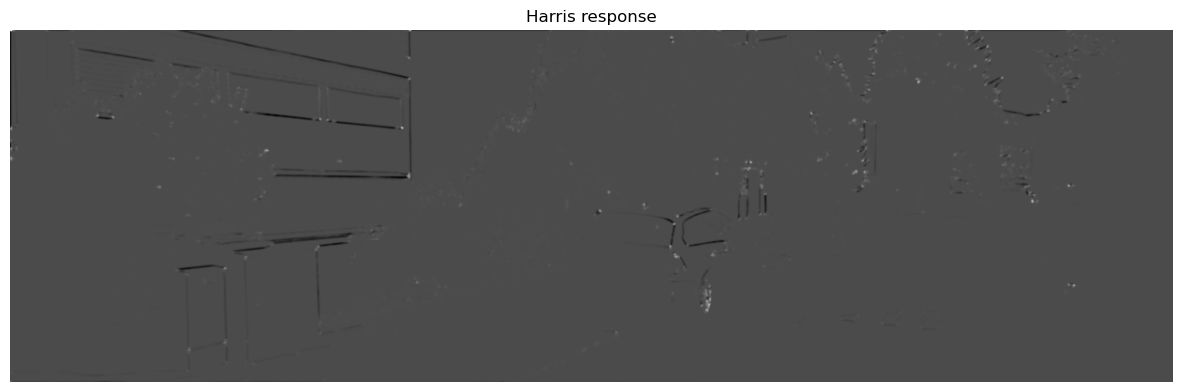

In [4]:
def create_harris_response(Ixx, Iyy, Ixy, alpha=0.06):
    """
    Calculates the Harris response for each pixel in an image.

    Args:
    Ixx (numpy.ndarray): The squared x-derivatives of the image.
    Iyy (numpy.ndarray): The squared y-derivatives of the image.
    Ixy (numpy.ndarray): The product of x and y derivatives of the image.
    alpha (float): Harris detector free parameter. Typically 0.04 to 0.06.

    Returns:
    numpy.ndarray: The Harris response of the image.
    """
    # Compute the determinant and trace of the matrix for each pixel
    det_M = Ixx * Iyy - Ixy * Ixy
    trace_M = Ixx + Iyy

    # Compute the Harris response
    R = det_M - alpha * (trace_M ** 2)
    return R

response = create_harris_response(Ixx, Iyy, Ixy)
display(response, 'Harris response')

Now we apply non maximum suppression to keep the pixels that are 0.01 above the global maximum.

In [5]:
def response_non_maxsup(R):
    """
    Applies non-maximum suppression to the Harris response map.

    Args:
    R (numpy.ndarray): The Harris response of an image.

    Returns:
    numpy.ndarray: Coordinates of the local maxima (corner points).
    """
    corner_points = feature.peak_local_max(R, min_distance=7, threshold_abs=0, threshold_rel=0.01)
    return corner_points

keypoints = response_non_maxsup(response)
print(len(keypoints))

319


Finally, we define a function that allows us to visualize all the keypoints detected in the image.

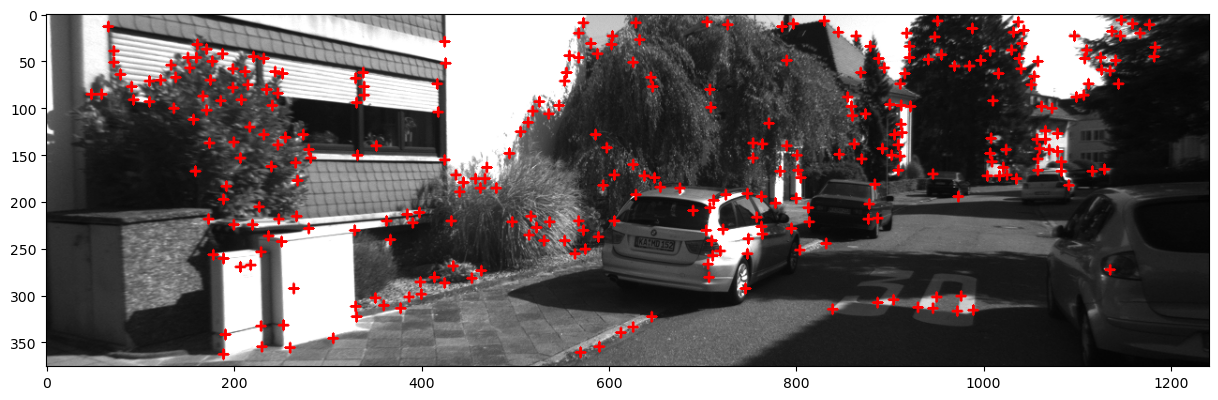

In [6]:
def keypoints_vis(image, list_keypoints):
    """
    Visualizes keypoints on an image with red '+' markers.

    Args:
    image (numpy.ndarray): The grayscale image.
    list_keypoints (List[Tuple[int, int]]): List of keypoints coordinates (row, column).

    Returns:
    numpy.ndarray: The image with keypoints visualized.
    """
    # Convert grayscale to color image by repeating channels
    image_color = cv2.merge([image, image, image]).astype(np.uint8)
    
    # Add a cross marker for each keypoint
    for keypoint in list_keypoints:
        # Invert coordinates to follow OpenCV convention (x, y) instead of (y, x)
        cv2.drawMarker(image_color, (keypoint[1], keypoint[0]), (255, 0, 0), markerType=cv2.MARKER_CROSS, markerSize=10, thickness=2, line_type=cv2.LINE_8)
    
    # Display the image with keypoints
    plt.figure() 
    plt.imshow(image_color)
    plt.show()
    return image_color

image_with_keypoints = keypoints_vis(image, keypoints)

Now that we have the keypoints we are going to write our own descriptors. For this we are going to take 32 pixel patches to use as descriptors.

In [7]:
def get_patches(image, keypoints, N=32):
    """
    Extracts square patches around each keypoint from the image.

    Args:
    image (numpy.ndarray): The grayscale image.
    keypoints (List[Tuple[int, int]]): List of keypoints coordinates.
    N (int): Size of the square patch.

    Returns:
    numpy.ndarray: Array of image patches.
    """
    descriptors = []
    # Extend the image borders
    image_ext = cv2.copyMakeBorder(image, top=N//2, bottom=N//2, left=N//2, right=N//2, borderType=cv2.BORDER_REPLICATE)
    
    # Extract patches centered at each keypoint
    for kp in keypoints:
        kp += N//2
        d = image_ext[kp[0]-N//2: kp[0]+N//2, kp[1]-N//2: kp[1]+N//2]
        descriptors.append([d])
    descriptors = np.array(descriptors)
    return descriptors

descriptors = get_patches(image, keypoints)

To make them more robust to changes in brightness, we now normalize each of the descriptors.

In [8]:
def normalize_patches(descriptors, epsilon=1*10**-7):
    """
    Normalizes each patch in the descriptors.

    Args:
    descriptors (numpy.ndarray): Array of image patches.
    epsilon (float): Small value to avoid division by zero.

    Returns:
    numpy.ndarray: Array of normalized patches.
    """
    des = []
    for d in descriptors:
        # Normalize patch
        d_norm = (d - np.mean(d)) / (np.std(d) - epsilon)
        des.append([d_norm])
    return np.array(des)

descriptors_normalized = normalize_patches(descriptors)

Now let's start finding the correspondences between two successive images. For that, we will first define our distance matrix, which takes into account the square of the Euclidean distance in each of the patches.

In [9]:
def create_distance_matrix(descriptor_1, descriptor_2):
    """
    Creates a distance matrix between two sets of descriptors.

    Args:
    descriptor_1 (numpy.ndarray): The first set of descriptors.
    descriptor_2 (numpy.ndarray): The second set of descriptors.

    Returns:
    numpy.ndarray: The distance matrix.
    """
    height = descriptor_1.shape[0]
    width = descriptor_2.shape[0]
    distance = np.zeros((height, width))

    for i in range(height):
        # Repeat the descriptor across the width
        repeated_d1 = descriptor_1[i, :, :].reshape(1, 32, 32).repeat(width, 0)
        # Compute the squared Euclidean distance
        dist = np.sum((repeated_d1 - descriptor_2) ** 2, axis=(1, 2)).reshape(1, -1)
        distance[i] = dist
    return distance

We will implement brute force matching for each of the descriptors, for best results, we will implement the 1NNN/2NNN ratio test with cross validation to get the best matches.

In [10]:
def find_matches_robust(distance_matrix):
    """
    Finds robust matches between keypoints using the distance matrix.

    Args:
    distance_matrix (numpy.ndarray): The distance matrix between two sets of descriptors.

    Returns:
    List[cv2.DMatch]: List of matches found.
    """
    rows = distance_matrix.shape[0]
    threshold = .75
    correspondences = []

    for i in range(rows):
        line = distance_matrix[i]
        # Sort to find the nearest and second nearest neighbor
        first_and_second = np.sort(line)[:2]
        # Apply ratio test
        if (first_and_second[0] / first_and_second[1]) < threshold:
            ind = np.argmin(line)
            # Cross-validation check
            if np.argmin(distance_matrix[:, ind]) == i:
                match = cv2.DMatch(i, ind, first_and_second[0])
                correspondences.append(match)
    return correspondences

In the same way, we define a function that allows us to visualize the correspondences between a frame and its successor, the green lines represent the displacement of each of the tracked descriptors between a frame and its successor.

In [11]:
def matches_vis(image_tgt, list_keypoints_src, list_keypoints_tgt, matches):
    """
    Visualizes matches between keypoints in the source and target images.

    Args:
    image_tgt (numpy.ndarray): Target image.
    list_keypoints_src (List[Tuple[int, int]]): List of keypoints in the source image.
    list_keypoints_tgt (List[Tuple[int, int]]): List of keypoints in the target image.
    matches (List[cv2.DMatch]): List of matches.

    Returns:
    numpy.ndarray: The target image with matches visualized.
    """
    # Convert grayscale to color image by repeating channels
    image_color = cv2.merge([image_tgt, image_tgt, image_tgt]).astype(np.uint8)
    
    # Add a cross marker for each keypoint in target image
    for keyp in list_keypoints_tgt:
        cv2.drawMarker(image_color, (keyp[1], keyp[0]), (255, 0, 0), markerType=cv2.MARKER_CROSS, markerSize=10, thickness=2, line_type=cv2.LINE_8)
    
    # Draw lines for matches
    for match in matches:
        src_idx = match.queryIdx
        tgt_idx = match.trainIdx
        src_pt, tgt_pt = list_keypoints_src[src_idx], list_keypoints_tgt[tgt_idx]
        cv2.line(image_color, (tgt_pt[1], tgt_pt[0]), (src_pt[1], src_pt[0]), (0, 255, 0), 1)
    
    # Display the image with matches
    plt.figure()
    plt.imshow(image_color)
    plt.axis('off')
    plt.show()
    return image_color

In [ ]:
images_directory = 'images'
output_directory = 'output_images'
images = sorted([img for img in os.listdir(images_directory) if img.endswith('.png')])
for i in range(len(images) - 1):
    # Open both images
    image_1 = cv2.imread(os.path.join(images_directory, images[i]), cv2.IMREAD_GRAYSCALE)
    image_2 = cv2.imread(os.path.join(images_directory, images[i + 1]), cv2.IMREAD_GRAYSCALE)

    # define the first gaussian kernel and apply the kernel to the both images
    gaussian_1 = create_gaussian_kernel(size=3, sigma=0.1)
    smooth_image_1 = signal.convolve2d(image_1, gaussian_1, mode="same",boundary='fill')
    smooth_image_2 = signal.convolve2d(image_2, gaussian_1, mode="same",boundary='fill')

    # compute the gradients for the both images
    Ix_1, Iy_1 = gradient_image(smooth_image_1)
    Ixx_1 = Ix_1 * Ix_1
    Iyy_1 = Iy_1 * Iy_1
    Ixy_1 = Ix_1 * Iy_1
    Ix_2, Iy_2 = gradient_image(smooth_image_2)
    Ixx_2 = Ix_2 * Ix_2
    Iyy_2 = Iy_2 * Iy_2
    Ixy_2 = Ix_2 * Iy_2

    # define the second gaussian kernel and apply to the kernels
    gaussian_2 = create_gaussian_kernel(size=5, sigma=1)
    Ixx_1 = signal.convolve2d(Ixx_1, gaussian_2, mode="same",boundary='fill')
    Ixy_1 = signal.convolve2d(Ixy_1, gaussian_2, mode="same",boundary='fill')
    Iyy_1 = signal.convolve2d(Iyy_1, gaussian_2, mode="same",boundary='fill')
    Ixx_2 = signal.convolve2d(Ixx_2, gaussian_2, mode="same",boundary='fill')
    Ixy_2 = signal.convolve2d(Ixy_2, gaussian_2, mode="same",boundary='fill')
    Iyy_2 = signal.convolve2d(Iyy_2, gaussian_2, mode="same",boundary='fill')

    # compute the harris response for both images
    response_1 = create_harris_response(Ixx_1, Iyy_1, Ixy_1)
    response_2 = create_harris_response(Ixx_2, Iyy_2, Ixy_2)

    # apply non maxsupp for the both images
    keypoints_1 = response_non_maxsup(response_1)
    keypoints_2 = response_non_maxsup(response_2)

    # visualize both images with the keypoints
    # keypoints_vis(image_1, keypoints_1)
    # keypoints_vis(image_2, keypoints_2)

    # get the descriptors and normalize it
    descriptors_1 = get_patches(image_1, keypoints_1)
    descriptors_normalized_1 = normalize_patches(descriptors_1)
    descriptors_2 = get_patches(image_2, keypoints_2)
    descriptors_normalized_2 = normalize_patches(descriptors_2)

    # create the distance matriz
    distance = create_distance_matrix(descriptors_normalized_1.squeeze(), descriptors_normalized_2.squeeze())

    # find the correspondances
    correspondances = find_matches_robust(distance)

    output_image = matches_vis(image_2,keypoints_1,keypoints_2,correspondances)
    cv2.imwrite(os.path.join(output_directory, images[i]), cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

This function allows us to create a video with all the previously generated images to see the displacement of each of the tracked descriptors between frames.

In [ ]:
def make_video(list_image_names):
    """
    Creates a video from a list of image filenames.

    Args:
    list_image_names (List[str]): List of image filenames.

    Returns:
    None: Writes the video to a file.
    """
    img_array = []
    for filename in sorted(list_image_names):
        img = cv2.imread(filename)
        img_array.append(img)

    # Determine the size of the video from the first image
    height, width, layers = img_array[0].shape
    size = (width, height)
    
    # Create a video writer object
    video_writer = cv2.VideoWriter('corner_tracking_patch.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 3, size)
    
    for img in img_array:
        video_writer.write(img)
    video_writer.release()
    return

In [ ]:
image_files = sorted([os.path.join(output_directory, img) for img in os.listdir(output_directory) if img.endswith('.png')])
# Llama a la función make_video
make_video(image_files)

## Corner tracking with SIFT features

Now we will do the same as we did before. The difference is that now, instead of using our patches we will use the SIFT descriptors. For this, when we create it we assign 0 to our angle variable.

/Users/pablopace/Desktop/public-projects/computer vision/corner detection and tracking/utils.py:230: RuntimeWarning: invalid value encountered in scalar divide
  if (first_and_second[0] / first_and_second[1]) < threshold:


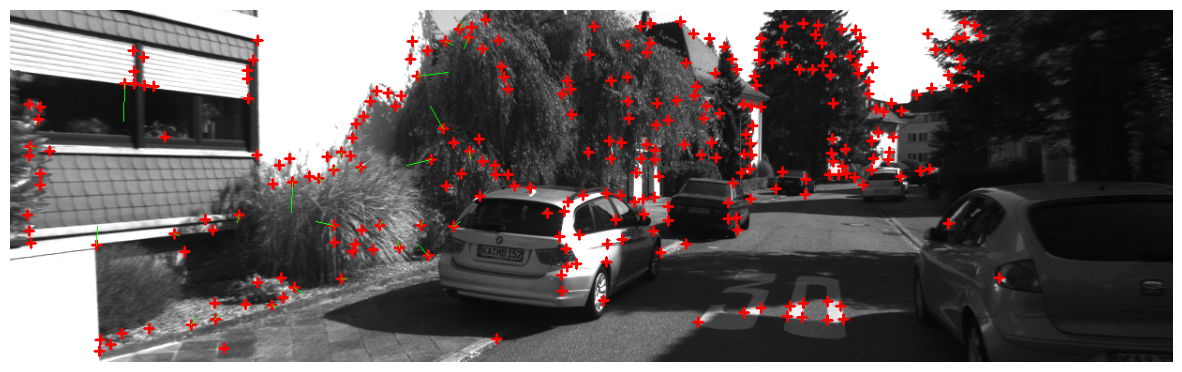

In [12]:
import utils
images_directory = 'images'
images = sorted([img for img in os.listdir(images_directory) if img.endswith('.png')])
i = 116

# Open both images
image_1 = cv2.imread(os.path.join(images_directory, images[i]), cv2.IMREAD_GRAYSCALE)
image_2 = cv2.imread(os.path.join(images_directory, images[i + 1]), cv2.IMREAD_GRAYSCALE)

# define the first gaussian kernel and apply the kernel to the both images
gaussian_1 = utils.create_gaussian_kernel(size=3, sigma=0.1)
smooth_image_1 = signal.convolve2d(image_1, gaussian_1, mode="same",boundary='fill')
smooth_image_2 = signal.convolve2d(image_2, gaussian_1, mode="same",boundary='fill')

# compute the gradients for the both images
Ix_1, Iy_1 = utils.gradient_image(smooth_image_1)
Ixx_1 = Ix_1 * Ix_1
Iyy_1 = Iy_1 * Iy_1
Ixy_1 = Ix_1 * Iy_1
Ix_2, Iy_2 = utils.gradient_image(smooth_image_2)
Ixx_2 = Ix_2 * Ix_2
Iyy_2 = Iy_2 * Iy_2
Ixy_2 = Ix_2 * Iy_2

# define the second gaussian kernel and apply to the kernels
gaussian_2 = utils.create_gaussian_kernel(size=5, sigma=1)
Ixx_1 = signal.convolve2d(Ixx_1, gaussian_2, mode="same",boundary='fill')
Ixy_1 = signal.convolve2d(Ixy_1, gaussian_2, mode="same",boundary='fill')
Iyy_1 = signal.convolve2d(Iyy_1, gaussian_2, mode="same",boundary='fill')
Ixx_2 = signal.convolve2d(Ixx_2, gaussian_2, mode="same",boundary='fill')
Ixy_2 = signal.convolve2d(Ixy_2, gaussian_2, mode="same",boundary='fill')
Iyy_2 = signal.convolve2d(Iyy_2, gaussian_2, mode="same",boundary='fill')

# compute the harris response for both images
response_1 = utils.create_harris_response(Ixx_1, Iyy_1, Ixy_1)
response_2 = utils.create_harris_response(Ixx_2, Iyy_2, Ixy_2)

# apply non maxsupp for the both images
keypoints_1 = utils.response_non_maxsup(response_1)
keypoints_2 = utils.response_non_maxsup(response_2)

keypoints_1_cv = [cv2.KeyPoint(x=int(kp[0]), y=int(kp[1]), size=32, angle=0) for kp in keypoints_1]
keypoints_2_cv = [cv2.KeyPoint(x=int(kp[0]), y=int(kp[1]), size=32, angle=0) for kp in keypoints_2]

sift = cv2.SIFT_create()
keypoints, descriptors_1 = sift.compute(image_1, keypoints_1_cv)
keypoints, descriptors_2 = sift.compute(image_1, keypoints_2_cv)

# create the distance matriz
distance = utils.create_distance_matrix_mod(descriptors_1, descriptors_2)

# find the correspondances
correspondances = utils.find_matches_robust(distance)

output_image = utils.matches_vis(image_2,keypoints_1,keypoints_2,correspondances)
# cv2.imwrite(os.path.join(output_directory, images[i]), cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))


This is the result we can see after performing the tracking for images 116 and 117 of the dataset. We can see that the tracking does not follow the real motion flow. This may be due to the setting of the angle of each descriptor to 0.